# Прогнозирование уровня средней заработной платы в России

Известные данные о заработной плате за каждый месяц с января 1993 по август 2016. Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Reading data
salary = pd.read_csv('WAG_C_M_full.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
print salary.shape
salary.head()

(306, 1)


,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


<Figure size 1080x504 with 0 Axes>

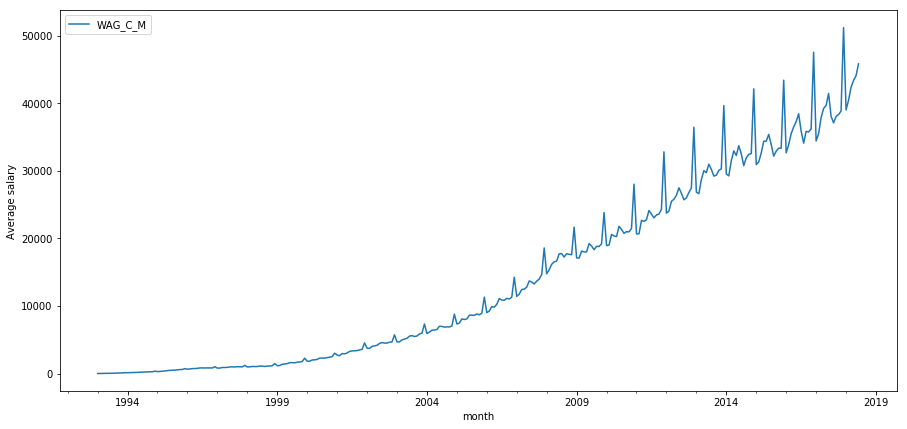

In [3]:
plt.figure(figsize(15,7))
salary.plot()
plt.ylabel('Average salary')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.998584310481


<Figure size 1080x720 with 0 Axes>

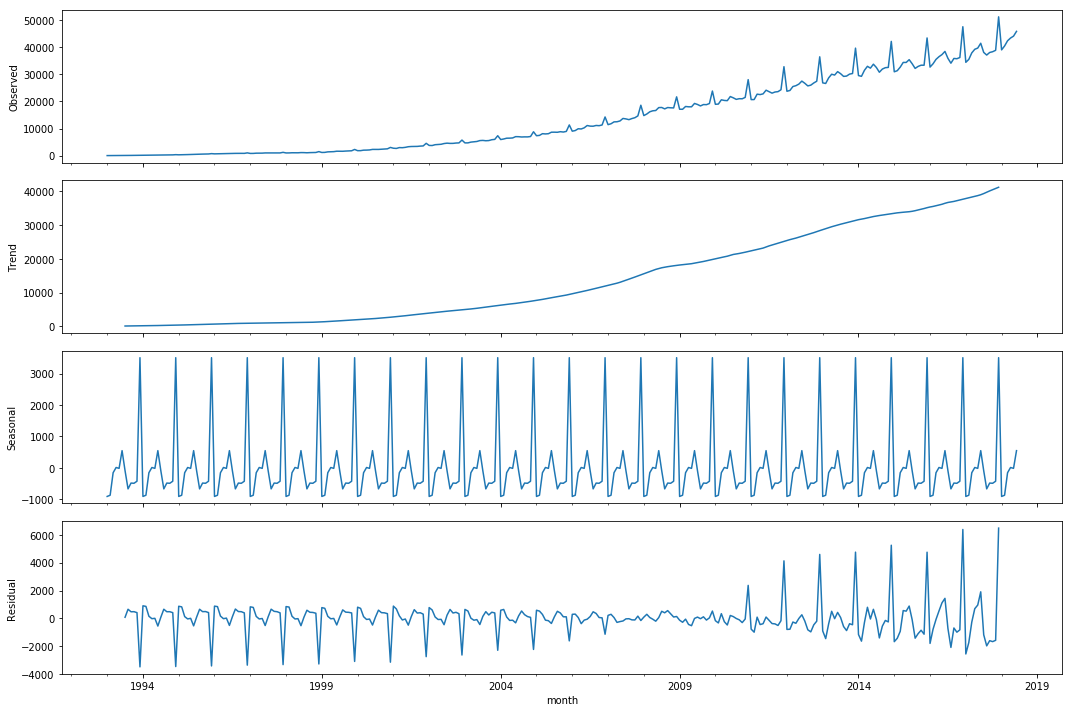

In [4]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary).plot()
print(u'Критерий Дики-Фуллера: p={}'.format(sm.tsa.stattools.adfuller(salary['WAG_C_M'])[1]))

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.278644
Критерий Дики-Фуллера: p=0.728912


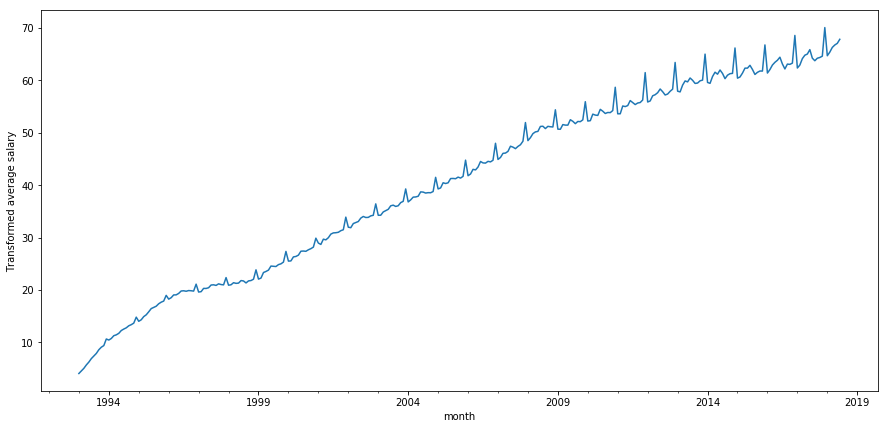

In [5]:
salary['wag_box_cox'], lmbda = stats.boxcox(salary['WAG_C_M'])
plt.figure(figsize(15,7))
salary['wag_box_cox'].plot()
plt.ylabel(u'Transformed average salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary['wag_box_cox'])[1])

### Стационарность

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.133489


<Figure size 1080x720 with 0 Axes>

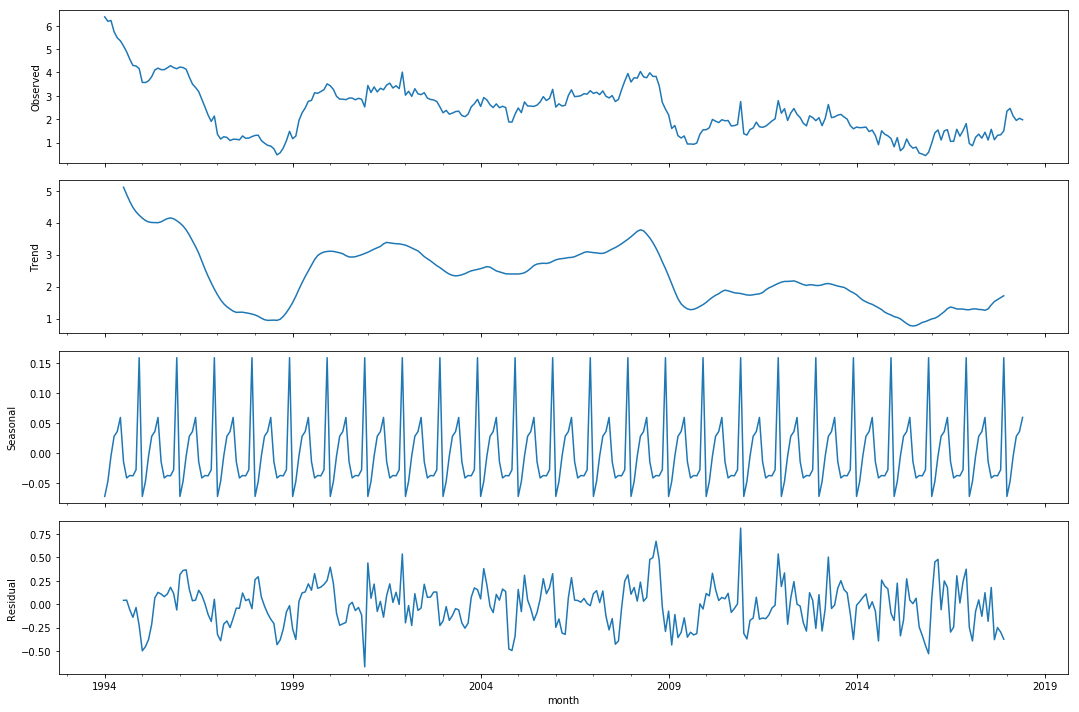

In [6]:
salary['wag_box_diff'] = salary['wag_box_cox'] - salary['wag_box_cox'].shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary['wag_box_diff'][12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary['wag_box_diff'][12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

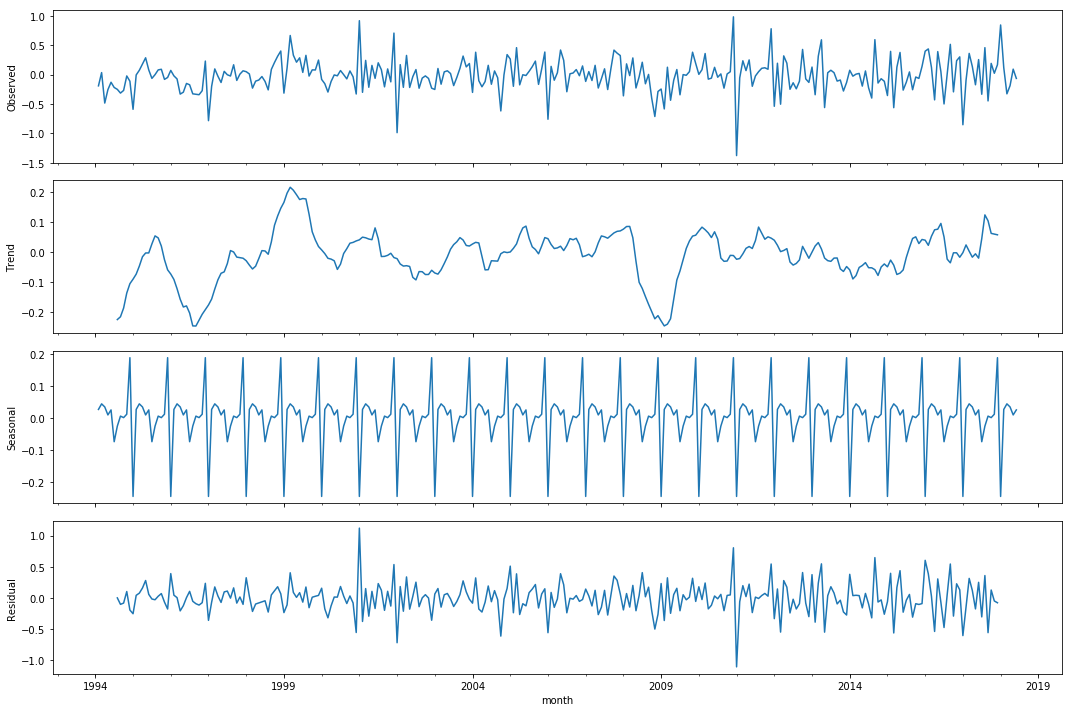

In [7]:
salary['wag_box_diff2'] = salary['wag_box_diff'] - salary['wag_box_diff'].shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary['wag_box_diff2'][13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary['wag_box_diff2'][13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

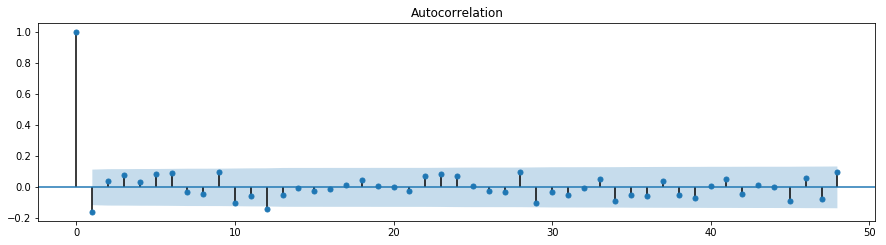

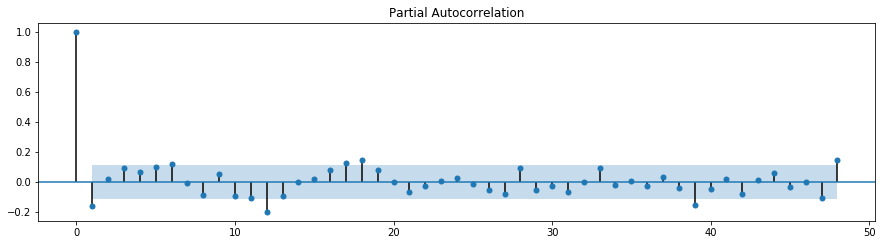

In [8]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary['wag_box_diff2'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary['wag_box_diff2'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=1, P=1, p=6

In [9]:
ps = range(0, 7)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [10]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

56

In [11]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary['wag_box_cox'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 0, 1))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 1, 1))
Wall time: 46.2 s


In [12]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
47  (6, 0, 1, 1)  82.078350
46  (6, 0, 1, 0)  83.437995
51  (6, 1, 1, 1)  83.836418
27  (3, 1, 1, 1)  84.946609
50  (6, 1, 1, 0)  84.998283


Лучшая модель:

In [13]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        wag_box_cox   No. Observations:                  306
Model:             SARIMAX(6, 1, 0)x(1, 1, 1, 12)   Log Likelihood                 -32.039
Date:                            Fri, 03 Aug 2018   AIC                             82.078
Time:                                    10:03:33   BIC                            115.200
Sample:                                01-01-1993   HQIC                            95.344
                                     - 06-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2335      0.044     -5.321      0.000      -0.319      -0.147
ar.L2         -0.0293      0.064   

Её остатки:

Критерий Стьюдента: p=0.395581
Критерий Дики-Фуллера: p=0.000000


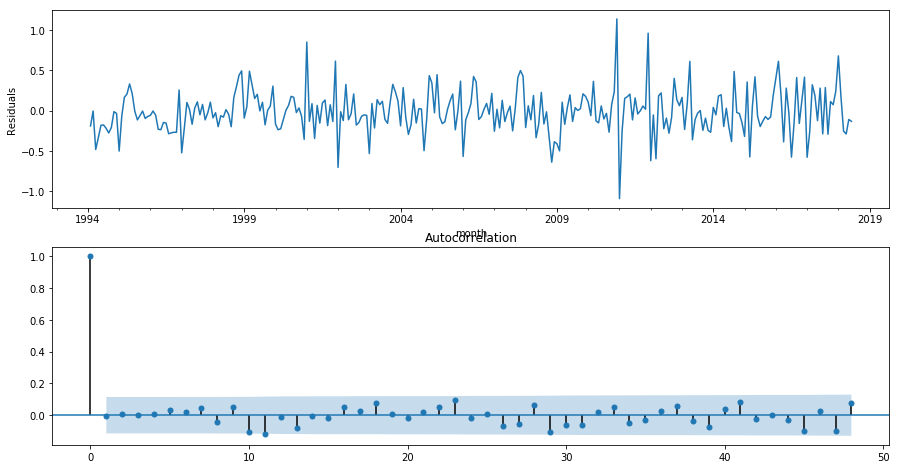

In [14]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

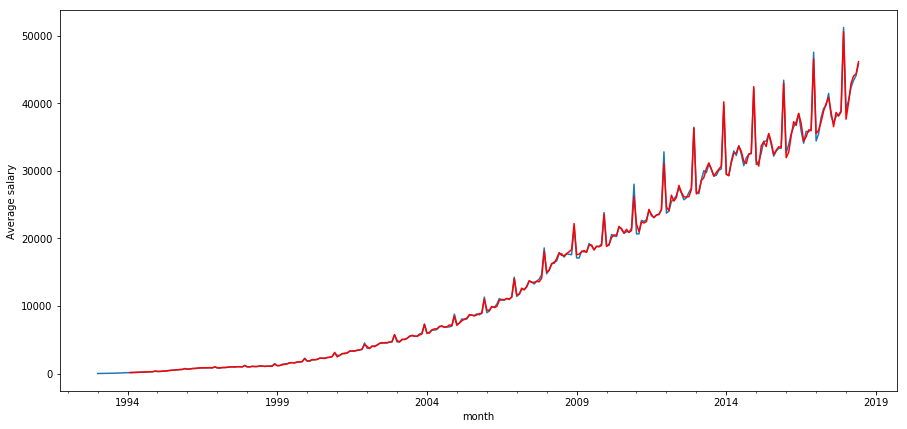

In [15]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary['WAG_C_M'].plot()
salary['model'][13:].plot(color='r')
plt.ylabel('Average salary')
pylab.show()

### Прогноз

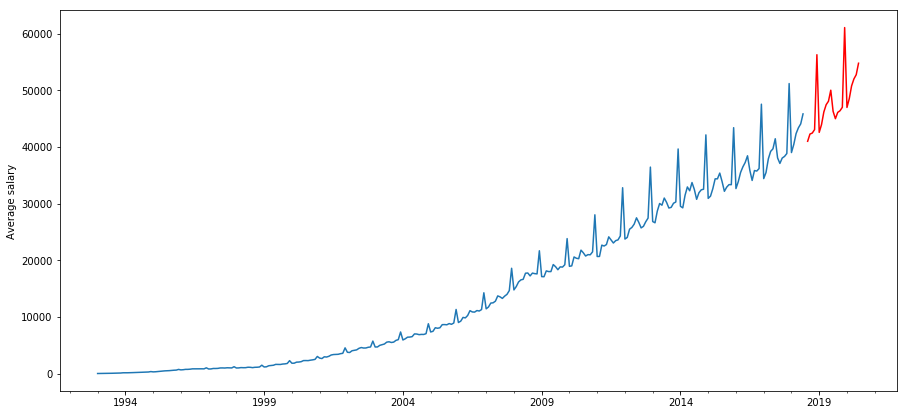

In [16]:
salary2 = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2018-07-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=307, end=330), lmbda)

plt.figure(figsize(15,7))
salary2['WAG_C_M'].plot()
salary2['forecast'].plot(color='r')
plt.ylabel('Average salary')
pylab.show()